In [3]:
import os, sys

import torch
import scipy.stats as st
from scipy.spatial.distance import pdist, squareform
import numpy as np
import pandas as pd
from tqdm.notebook import trange

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns

In [4]:
for p in ['../spotlight_ext']:
    module_path = os.path.abspath(os.path.join(p))
    if module_path not in sys.path:
        sys.path.append(module_path)

models_path = '../models'

In [5]:
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset

# get dataset
dataset = get_movielens_dataset(variant='1M')
train, test = random_train_test_split(dataset, random_state=np.random.RandomState(2020))

max_sequence_length = 20
train = train.to_sequence(max_sequence_length=max_sequence_length)
test = test.to_sequence(max_sequence_length=max_sequence_length)

In [6]:
# load trained model
# ofile = 'entire_model_1m.pt'
ofile = 'entire_model_1m_20interactions.pt'
model = torch.load(os.path.join(models_path, ofile))

## Compute losses

In [7]:
def compute_yloss(curr_score, kth_score):
    yloss = 0.0
    for i in range(total_CFs):
        temp_loss = curr_score/kth_score

        yloss += temp_loss    

    return yloss/total_CFs    

In [8]:
def compute_dist(x_hat, x1):
    """Compute weighted distance between two vectors."""
#     return sum(abs(x_hat - x1))
    diff = set(x1).difference(set(x_hat))
    return len(diff)

def compute_proximity_loss(cfs, x1):
    proximity_loss = 0.0
    for i in range(total_CFs):        
        proximity_loss += compute_dist(cfs[i], x1)
    return proximity_loss/total_CFs

In [9]:
def compute_diversity_loss():
    proximity_loss = 0.0
    return proximity_loss/total_CFs

In [10]:
def compute_loss():
    """Computes the overall loss"""
    yloss = compute_yloss()
    proximity_loss = compute_proximity_loss() if proximity_weight > 0 else 0.0
    diversity_loss = compute_diversity_loss() if diversity_weight > 0 else 0.0    

    loss = yloss + (proximity_weight * proximity_loss) - (diversity_weight * diversity_loss)
    return loss

In [24]:
FLOAT_MAX = np.finfo(np.float32).max

class ItemInteractionInfo:
    user_id = -1
    item_id = -1
    score = 0
    pos = -1
    interactions = []
    complete_interactions = []
    recommends = []
    iter_no = -1
    satisfy_objective = True
    satisfy_contraints = True
    y_loss = 1.0
    proximity_loss = FLOAT_MAX
    solution_found = False
    
    def __init__(self, uid, iid=-1, p=-1, i=None, fobj=True, fconstraint=True):
        self.user_id = uid
        self.item_id = iid
        self.pos = p
        self.interactions = i
        self.satisfy_objective = fobj
        self.satisfy_contraints = fconstraint
        
    def __str__(self): 
        sorted_recommended_items = [(n[0], n[1].detach().numpy().flatten()[0]) if isinstance(n[1], torch.Tensor) else (n[0], n[1]) for n in self.recommends]
            
        return (f'\n'
                f'user_id: {self.user_id}, item_id: {self.item_id}\n'
                f'yloss: {round(self.y_loss, 4)}, proximity_loss: {int(self.proximity_loss)}\n'
                f'Item {self.item_id} is in position {self.pos} now!!!\n'
                f'Found in iteration {self.iter_no} and the interacted items are {self.interactions}\n'
                f'10-best recommended items {sorted_recommended_items}\n')
    
    def set_flags(self, do_objective, do_contraints):
        self.satisfy_objective = do_objective
        self.satisfy_contraints = do_contraints
    
    def needs_update(self, loss):        
        if len(loss):
            if (not self.satisfy_contraints or self.y_loss > loss['yloss']) and (not self.satisfy_objective or self.proximity_loss >= loss['proximity']):
                return True
        
        return False    
    
    def set_values(self, predictions, interacted_items, tot_interacted_items, loss, iter_no, k=10):
        # get the ranking position of selected item in the list
        self.pos = st.rankdata(-predictions, method='ordinal')[self.item_id]
        self.recommends = sorted(enumerate(predictions), key=lambda x: x[1], reverse=True)[:k]
        self.iter_no = iter_no
        self.y_loss = loss[0]
        self.proximity_loss = loss[1]
        self.interactions = interacted_items
        self.complete_interactions = tot_interacted_items
        
        self.solution_found = True

## Example code

In [20]:
# initialize input parameters
k = 10
no_interactions = 10
total_CFs = 1
max_interacted_items_to_del = 4
user_id = 8

proximity_weight, diversity_weight = 1, 0

FLOAT_MAX = np.finfo(np.float32).max

In [21]:
items_interacted = test.sequences[test.user_ids==user_id][0]
predictions = -model.predict(items_interacted[:min(no_interactions, len(items_interacted))])
predictions[items_interacted] = FLOAT_MAX

print(f'Given the following interactions {items_interacted[:no_interactions]} for user {user_id}, the top-{k} recommended items are '
      f'{list(predictions.argsort()[:k])}')
cand_pos = input('Select item (position) to exclude from recommended list: ')
try:
    cand = predictions.argsort()[min(k, int(cand_pos)) - 1]
except ValueError:
    print("That's not an int!")

print(f'The selected item in pos {cand_pos} is {cand}\n')

Given the following interactions [384 461 236 478  86 457 511  60 323 443] for user 8, the top-10 recommended items are [266, 372, 594, 227, 485, 1277, 705, 325, 90, 508]


Select item (position) to exclude from recommended list:  5


The selected item in pos 5 is 485



In [26]:
from itertools import permutations, combinations
import torch.nn.functional as F


counter = 1
best_total_loss = ItemInteractionInfo(user_id, cand)
best_yloss = ItemInteractionInfo(user_id, cand, fobj=False)

for l in range(1, min(max_interacted_items_to_del, len(items_interacted)) + 1):
    print(f'Checking with {l} interacted items removed...')
#     produce permutations of various interactions
    perm = combinations(items_interacted[:min(no_interactions, len(items_interacted))], min(no_interactions, len(items_interacted)) - l)    

    for i in perm:        
#         predict next top-k items about to be selected        
        preds = model.predict(i)
#     convert logits produced by model, i.e., the probability distribution before normalization, by using softmax
        tensor = torch.from_numpy(preds).float()
        preds = F.softmax(tensor, dim=0)
        
        yloss = compute_yloss(preds.numpy()[cand], preds.numpy()[reversed(preds.argsort())[k]])
        proximity_loss = compute_proximity_loss(np.asarray(i)[np.newaxis, :], items_interacted)    
#     keep info about the best solution found depending on an objective function
        if best_total_loss.needs_update(dict(yloss=yloss, proximity=proximity_loss)):             
            best_total_loss.set_values(preds, i, items_interacted, [yloss, proximity_loss], counter, k)
        if best_yloss.needs_update(dict(yloss=yloss, proximity=proximity_loss)):            
            best_yloss.set_values(preds, i, items_interacted, [yloss, proximity_loss], counter, k) 

        counter += 1

similarity_rank = k - st.rankdata(similarity_matrix[cand, items_interacted]) + 1

print('\nBest total loss\n', '=' * len('Best total loss'), best_total_loss)
idx_items_exluded = np.where(np.isin(items_interacted, list(set(items_interacted).difference(set(best_total_loss.interactions)))))
print('Similarities of removed items: ', similarity_rank[idx_items_exluded])

print('\nBest yloss\n', '=' * len('Best yloss'), best_yloss)
idx_items_exluded = np.where(np.isin(items_interacted, list(set(items_interacted).difference(set(best_yloss.interactions)))))
print('Similarities of removed items: ', similarity_rank[idx_items_exluded])

print(f'\nTotal iterations: {counter}')

Checking with 1 interacted items removed...
Checking with 2 interacted items removed...
Checking with 3 interacted items removed...
Checking with 4 interacted items removed...

Best total loss
user_id: 8, item_id: 485
yloss: 0.881, proximity_loss: 12
Item 485 is in position 19 now!!!
Found in iteration 17 and the interacted items are (384, 461, 236, 478, 86, 511, 60, 323)
10-best recommended items [(227, 0.0046888264), (594, 0.0045607807), (372, 0.004343697), (461, 0.003976637), (124, 0.0039312975), (539, 0.0037927055), (1277, 0.0037833683), (266, 0.0036134752), (325, 0.0035272632), (439, 0.0034671403)]

Similarities of removed items:  [ 4.  9.  3. -3. -5. -1.  8.  0.  1. 10.  5.  2.]

Best yloss
user_id: 8, item_id: 485
yloss: 0.5166, proximity_loss: 14
Item 485 is in position 88 now!!!
Found in iteration 178 and the interacted items are (384, 461, 236, 478, 86, 60)
10-best recommended items [(325, 0.006310096), (227, 0.005587188), (471, 0.005130091), (60, 0.004904969), (897, 0.003595

## Optimized technique using item-similarities

In [220]:
# compute the item-item similarity matrix utilizing ratings
# adjusted cosine similarity on ratings

# construct 
M = np.zeros((dataset.num_users, dataset.num_items))
for u in range(1, dataset.num_users):    
    np.add.at(M[u], dataset.item_ids[dataset.user_ids==u], dataset.ratings[dataset.user_ids==u])

M_u = M.mean(axis=1)
item_mean_subtracted = M - M_u[:, np.newaxis]
similarity_matrix = 1 - squareform(pdist(item_mean_subtracted.T, 'cosine'))

In [15]:
# compute the item-item similarity matrix utilizing implicit feedback, i.e., whether interacted or not with an item
# jaccard is used to build the matrix

M = np.zeros((dataset.num_users, dataset.num_items), dtype=np.bool)
for u in trange(1, dataset.num_users):    
    np.add.at(M[u], dataset.item_ids[dataset.user_ids==u], dataset.ratings[dataset.user_ids==u])

similarity_matrix = 1 - squareform(pdist(M.T, 'jaccard'))

In [ ]:
from itertools import permutations, combinations
import torch.nn.functional as F


# initial input parameters
max_interacted_items_to_del = 5
cand_pos = 3
top_k = 10
total_CFs = 1

best_tot_loss_data = []
best_yloss_data = []
users_no_data = []

# print(f'Checking for user', end='')
# delimiter = ''
for user_id in trange(1, dataset.num_users):
#     print(f'{delimiter} {user_id}', end='')
#     delimiter = ','
    
    seq_size = len(test.sequences[test.user_ids==user_id])
    best_total_loss = [None] * seq_size
    best_yloss = [None] * seq_size
    
    for j in range(seq_size):    
        if all(v > 0 for v in test.sequences[test.user_ids==user_id][j]):    
            items_interacted = test.sequences[test.user_ids==user_id][j]
            predictions = -model.predict(items_interacted)
            predictions[items_interacted] = FLOAT_MAX
            
            kth_item = predictions.argsort()[top_k - 1]
            rec_item_exclude = predictions.argsort()[min(top_k, int(cand_pos)) - 1]
            
            best_total_loss[j] = ItemInteractionInfo(user_id, rec_item_exclude)
            best_yloss[j] = ItemInteractionInfo(user_id, rec_item_exclude, fobj=False)

            counter = 1        

            for l in range(len(items_interacted) - 1, 0,-1):
                if best_total_loss[j].solution_found: break
                
                # produce permutations of various interactions
                perm = combinations(items_interacted, l)    

                for i in perm:
                    # predict next top-k items about to be selected        
                    preds = model.predict(i) 
                    # convert logits produced by model, i.e., the probability distribution before normalization, by using softmax
                    tensor = torch.from_numpy(preds).float()
                    preds = F.softmax(tensor, dim=0)

                    yloss = compute_yloss(preds.numpy()[rec_item_exclude], preds.numpy()[kth_item])
                    proximity_loss = compute_proximity_loss(np.asarray(i)[np.newaxis, :], items_interacted)    
                    # keep info about the best solution found depending on an objective function
                    if best_total_loss[j].needs_update(dict(yloss=yloss, proximity=proximity_loss)):
                        best_total_loss[j].set_values(preds, i, items_interacted, [yloss, proximity_loss], counter, top_k)                        
#                     if best_yloss[j].needs_update(dict(yloss=yloss, proximity=proximity_loss)):
#                         best_yloss[j].set_values(preds, i, items_interacted, [yloss, proximity_loss], counter, k)                 

                    counter += 1     
            
#     except IndexError as err:        
#         users_no_data.append(user_id)
        
    best_tot_loss_data.append(best_total_loss)
    best_yloss_data.append(best_yloss)

# print('\nProcess ended')

In [605]:
# save results to df

total_data = []
for items in best_tot_loss_data:
    for idx, rec in enumerate(items):
        if rec is None: continue
                
        similarity_rank = len(rec.complete_interactions) - st.rankdata(similarity_matrix[rec.item_id, rec.complete_interactions]) + 1
        del_items_indices = np.where(np.isin(rec.complete_interactions, list(set(rec.complete_interactions).difference(set(rec.interactions)))))
#         total_data.extend(list(similarity_rank[del_items_indices].astype(int)))
        
        total_data.append([
            rec.user_id, idx, rec.item_id, rec.y_loss, rec.proximity_loss, 
            ','.join(map(str, sorted(similarity_rank[del_items_indices].astype(int)))),
            ','.join(map(str, set(rec.complete_interactions).difference(set(rec.interactions)))),
        ])

In [605]:
df_7th = pd.DataFrame(total_data, columns=['user_id', 'pos', 'rec_item_id', 'yloss', 'proximity_loss', 'sim_rank', 'del_iitems'])
df_7th['proximity_loss'] = df_7th['proximity_loss'].astype(int)

# Stats related to the 7th item excluded from the top-10 recommendation list

In [585]:
from collections import Counter


non_solvable_cases = []
total_data = []
for items in best_tot_loss_data:
    for rec in items:
        if rec is None: continue
            
        if not rec.solution_found: 
            non_solvable_cases.append(rec.user_id)
            continue

        similarity_rank = len(rec.complete_interactions) - st.rankdata(similarity_matrix[rec.item_id, rec.complete_interactions]) + 1
        del_items_indices = np.where(np.isin(rec.complete_interactions, list(set(rec.complete_interactions).difference(set(rec.interactions)))))
        total_data.extend(list(similarity_rank[del_items_indices].astype(int)))
    
cnt = Counter(total_data)

In [586]:
# with matplotlib
# plt.hist(list(cnt.keys()), weights=list(cnt.values()), width=0.8)

Text(0.5, 0.98, 'Counting all similarity positions of each discovered counterfactual')

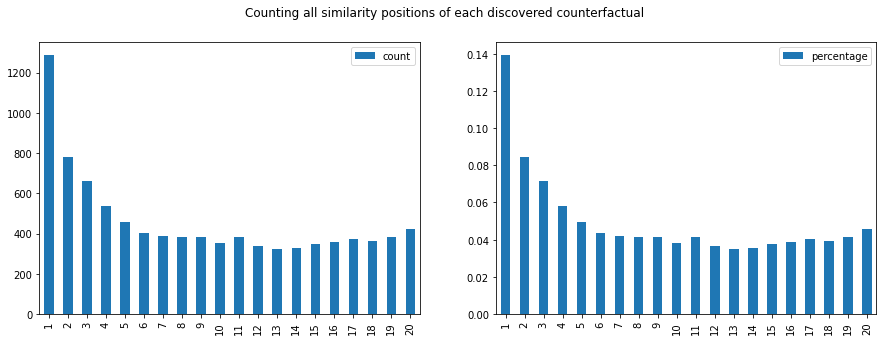

In [587]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

df = pd.DataFrame.from_dict(cnt, orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[0])
df.sort_index().plot.bar(y='percentage', ax=axs[1])

plt.suptitle('Counting all similarity positions of each discovered counterfactual')

In [588]:
from collections import Counter


non_solvable_cases = []
total_data = []
for items in best_tot_loss_data:
    for rec in items:
        if rec is None: continue
            
        if not rec.solution_found: 
            non_solvable_cases.append(rec.user_id)
            continue

        total_data.append(rec.proximity_loss)
    
cnt = Counter(total_data)

Text(0.5, 0.98, 'No of items to exclude from interacted list to have the recommendations change accordingly')

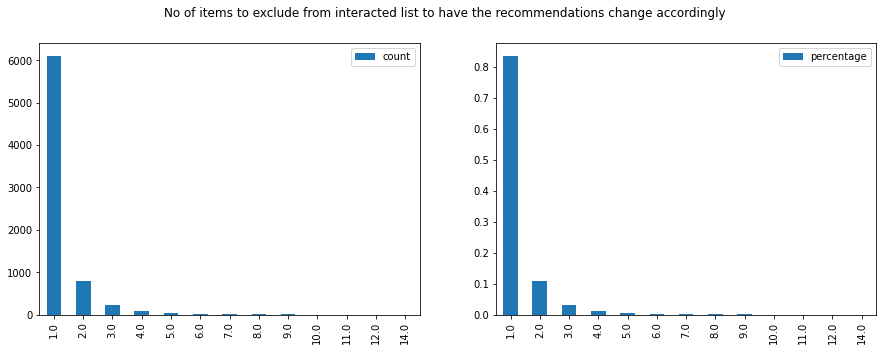

In [589]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

df = pd.DataFrame.from_dict(cnt, orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[0])
df.sort_index().plot.bar(y='percentage', ax=axs[1])

plt.suptitle('No of items to exclude from interacted list to have the recommendations change accordingly')

In [600]:
from collections import Counter


non_solvable_cases = []
total_data = []
for items in best_tot_loss_data:
    for rec in items:
        if rec is None: continue
            
        if not rec.solution_found: 
            non_solvable_cases.append(rec.user_id)
            continue

        similarity_rank = len(rec.complete_interactions) - st.rankdata(similarity_matrix[rec.item_id, rec.complete_interactions]) + 1
        del_items_indices = np.where(np.isin(rec.complete_interactions, list(set(rec.complete_interactions).difference(set(rec.interactions)))))
        total_data.extend(sorted(similarity_rank[del_items_indices].astype(int)[-1:]))        
    
cnt = Counter(total_data)

Text(0.5, 0.98, 'Counting the worst similarity position of each discovered counterfactual')

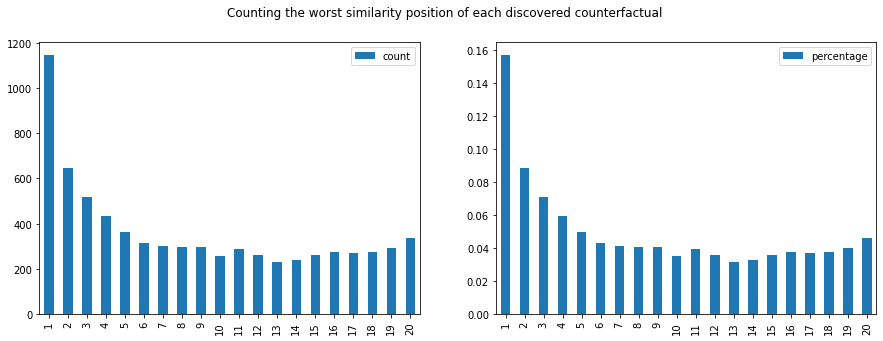

In [601]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

df = pd.DataFrame.from_dict(cnt, orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[0])
df.sort_index().plot.bar(y='percentage', ax=axs[1])

plt.suptitle('Counting the worst similarity position of each discovered counterfactual')